In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import pandas as pd
from shapely.geometry import Point


%load_ext autoreload
%autoreload 2
sns.set()
%matplotlib inline

# Parameters for calculation


A dictionary is supplied to the function to define the three components: distance, timedistance, and attribute distance.

The keys expected are: `distance`, `timedistance`, `attributes`

Each of these have a dictionary with the following keys: `fieldnames`, `function`, `weights` and `normalize_n`|`normalize_k`|`normalize_mean`

`fieldnames` provides the name of the fields in the table that specify the data for that component. The `distance\fieldnames` expects a dictionary with `x` and `y` information. The `timedistance` expects a dictionary with a `datetime` key, and attributes expects a list of field names.

`function` defines the function to be used to calculate the distance between two rows in the table. These can be defined as lambda functions: lambda x,y: what the function does. Two values (x and y) need to be passed to the function because there will always be two rows being compared. With `attributes` `function` expects a list of functions that correspond to each attribute.

`weights` are the weight to be applied to that particular component. `weights` for `attributes` expects a list of weights for each field.


Each component expects the distance value to be normalized by an amount. There are three options: `normalize_n`,`normalize_k`,and `normalize_mean`

`normalize_n` divides the distance by the number that is provided. If not using this provide a value of `None`. This should work for any of the components

`normalize_k` divides the distance by the maximum of the k nearest neighbors where k is the value provided. This should work with the distance component. If not using this provide a value of `None`.

`normalize_mean` divides the distance by the mean of that field. If not using this provide a value of `False`.



### Functions

Functions should expect two arrays `x` and `y` where x has a length of $1\text{x}k$ (number of variables, or 2 for latitude and longitude), and y has a length of $(n-1)\text{x}k$. This helps with the speed of processing data.

`lambda x,y: spatial.distance.cdist([x],y)` uses the scipy cdist function to calculate the distance between 1 point (`x`) and all the points in `y`

`lambda x,y: np.vectorize(lambda z: np.abs(z.days))(x-y)` Takes the difference between timepoint 1 (`x`) and all other timepoints in `y`, then retrieves the absolute days between them.

`lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1)` Is the absolute difference between value 1 (`x`) and all other values in `y`. This divided by the maximum between x and y, or 1 (this is to catch any division by zero errors). This normalizes the data between 0 and 1, so normalize_n parameter is set to 1.

In [2]:
from scipy import spatial

params = {"distance":{"fieldnames":{"x":"ShootLong","y":"ShootLat"},"function": lambda x,y: spatial.distance.cdist([x],y), 
                      "normalize_n": None, "normalize_k":12,"normalize_mean": False, "weights":1.0}, #Euclidean distance between two points, normalized by the maximum distance of the 6 nearest neighbors
          #"timedistance":{"fieldnames":{"datetime":"DateTime"},"function": lambda x,y: np.vectorize(lambda z: np.abs(z.days))(x-y), 
          #        "normalize_n": 60, "normalize_k": None,"normalize_mean": False, "weights":1.0}, #Absolute distance in days, normalized by 60 days.
          
          # Try YearQuarter time distance -> still absolute measure
          "timedistance":{"fieldnames":{"datetime":"YearQuarter"},"function": lambda x,y: np.abs(x-y),
                                        "normalize_n": None, "normalize_k":12,"normalize_mean": False, "weights":1.0}, #Euclidean distance between two points, normalized by the maximum distance of the 6 nearest neighbors
          
          # Leave out Depth in attributes (cause sampling always at bottom)
          "attributes":{"fieldnames":["Gadus_morhua_juvenile","Gadus_morhua_adult"],#"Depth"],
                        "function": [lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1),lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1)],
                        "normalize_n":[1,1,1], "normalize_k": [None,None,None], "normalize_mean": [False,False,False], "weights":[1.0,1.0,1.0]}} #Absolute difference between two values, normalized by the average of that field



In [ ]:
from scipy import spatial

params = {"distance":{"fieldnames":{"x":"ShootLong","y":"ShootLat"},"function": lambda x,y: spatial.distance.cdist([x],y), 
                      "normalize_n": None, "normalize_k":12,"normalize_mean": False, "weights":1.0}, #Euclidean distance between two points, normalized by the maximum distance of the 6 nearest neighbors
          #"timedistance":{"fieldnames":{"datetime":"DateTime"},"function": lambda x,y: np.vectorize(lambda z: np.abs(z.days))(x-y), 
          #        "normalize_n": 60, "normalize_k": None,"normalize_mean": False, "weights":1.0}, #Absolute distance in days, normalized by 60 days.
          
          # Try YearQuarter time distance -> still absolute measure
          "timedistance":{"fieldnames":{"datetime":"YearQuarter"},"function": lambda x,y: np.abs(x-y),
                                        "normalize_n": None, "normalize_k":12,"normalize_mean": False, "weights":1.0}, #Euclidean distance between two points, normalized by the maximum distance of the 6 nearest neighbors
          
          # Leave out Depth in attributes (cause sampling always at bottom)
          # Include Quarter (Seasonality: Spring, Fall) as an attribute
          "attributes":{"fieldnames":["Gadus_morhua_juvenile","Gadus_morhua_adult","Quarter"]#,"Depth"],
                        "function": [lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1),lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1),lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1)],
                        "normalize_n":[1,1,1], "normalize_k": [None,None,None], "normalize_mean": [False,False,False], "weights":[1.0,1.0,1.0]}} #Absolute difference between two values, normalized by the average of that field



In [3]:
params

{'distance': {'fieldnames': {'x': 'ShootLong', 'y': 'ShootLat'},
  'function': <function __main__.<lambda>(x, y)>,
  'normalize_n': None,
  'normalize_k': 12,
  'normalize_mean': False,
  'weights': 1.0},
 'timedistance': {'fieldnames': {'datetime': 'YearQuarter'},
  'function': <function __main__.<lambda>(x, y)>,
  'normalize_n': None,
  'normalize_k': 12,
  'normalize_mean': False,
  'weights': 1.0},
 'attributes': {'fieldnames': ['Gadus_morhua_juvenile', 'Gadus_morhua_adult'],
  'function': [<function __main__.<lambda>(x, y)>,
   <function __main__.<lambda>(x, y)>],
  'normalize_n': [1, 1, 1],
  'normalize_k': [None, None, None],
  'normalize_mean': [False, False, False],
  'weights': [1.0, 1.0, 1.0]}}

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/markrademaker/Projects/Spatio_temporal_clustering/Script/sthc_mark.py'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from sthc_mark import STHC
file_dir ='/Users/markrademaker/Projects/Spatio_temporal_clustering/'

In [6]:
st = STHC()

In [7]:
#st.load_dataset_csv('Gadus_morhua_1977_2019_juv_adult_biomass.csv',
#                    params,32631,sample=600) 
st.load_dataset_csv('/Users/markrademaker/Projects/Spatio_temporal_clustering/Data/Gadus_morhua_1991_2019_juv_adult_biomass.csv',
                    params,toepsg=4326,sample=600) 
st.df.head()

Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....


,Unnamed: 0,Survey,Year,Quarter,DateTime,ShootLat,ShootLong,Depth,Gadus_morhua_juvenile,Gadus_morhua_adult,YearQuarter,dist_norm,timenorm,attnorm0,attnorm1
9696,14571,NS-IBTS,2005,3,08-09-2005 05:18:00 AM,55.4051,6.8233,27,0.000000,0.00000,30,1.665250,2.665250,1.0,1.0
3555,8531,NS-IBTS,1997,1,02-02-1997 01:01:00 PM,57.4000,2.2333,82,0.191282,0.00000,13,1.694028,2.694028,1.0,1.0
15075,20380,NS-IBTS,2013,3,31-07-2013 10:11:00 AM,57.0400,-1.8160,90,1.245227,0.00000,46,1.810284,2.810284,1.0,1.0
4331,9237,NS-IBTS,1998,1,11-02-1998 11:41:00 AM,54.5667,3.3167,42,0.453392,100.90664,15,1.695666,2.695666,1.0,1.0
17868,23064,NS-IBTS,2017,3,21-07-2017 02:40:00 PM,52.3350,2.7437,45,0.000000,0.00000,54,1.688879,2.688879,1.0,1.0


/Users/markrademaker/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


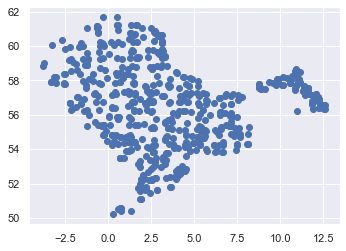

In [8]:
gdf = gpd.GeoDataFrame(st.df,geometry=st.df[['ShootLong','ShootLat']].apply(lambda x: Point(x),axis=1),crs={'init': 'epsg:4326'})
gdf.plot();

## Create the distance matrix

In [9]:
from scipy import spatial

st.calculate_distance_matrix()
st.calculate_clusters()

In [ ]:
#given how long it potentially takes to create the distance matrix it may be worth saving it for use later
#np.save("Clupea_harengus_attributes_dm",st.dm)


In [ ]:
#loading the distance matrix if it is saved
#dm = np.load("Clupea_harengus_attributes_dm.npy")

Try 272.0 clusters...


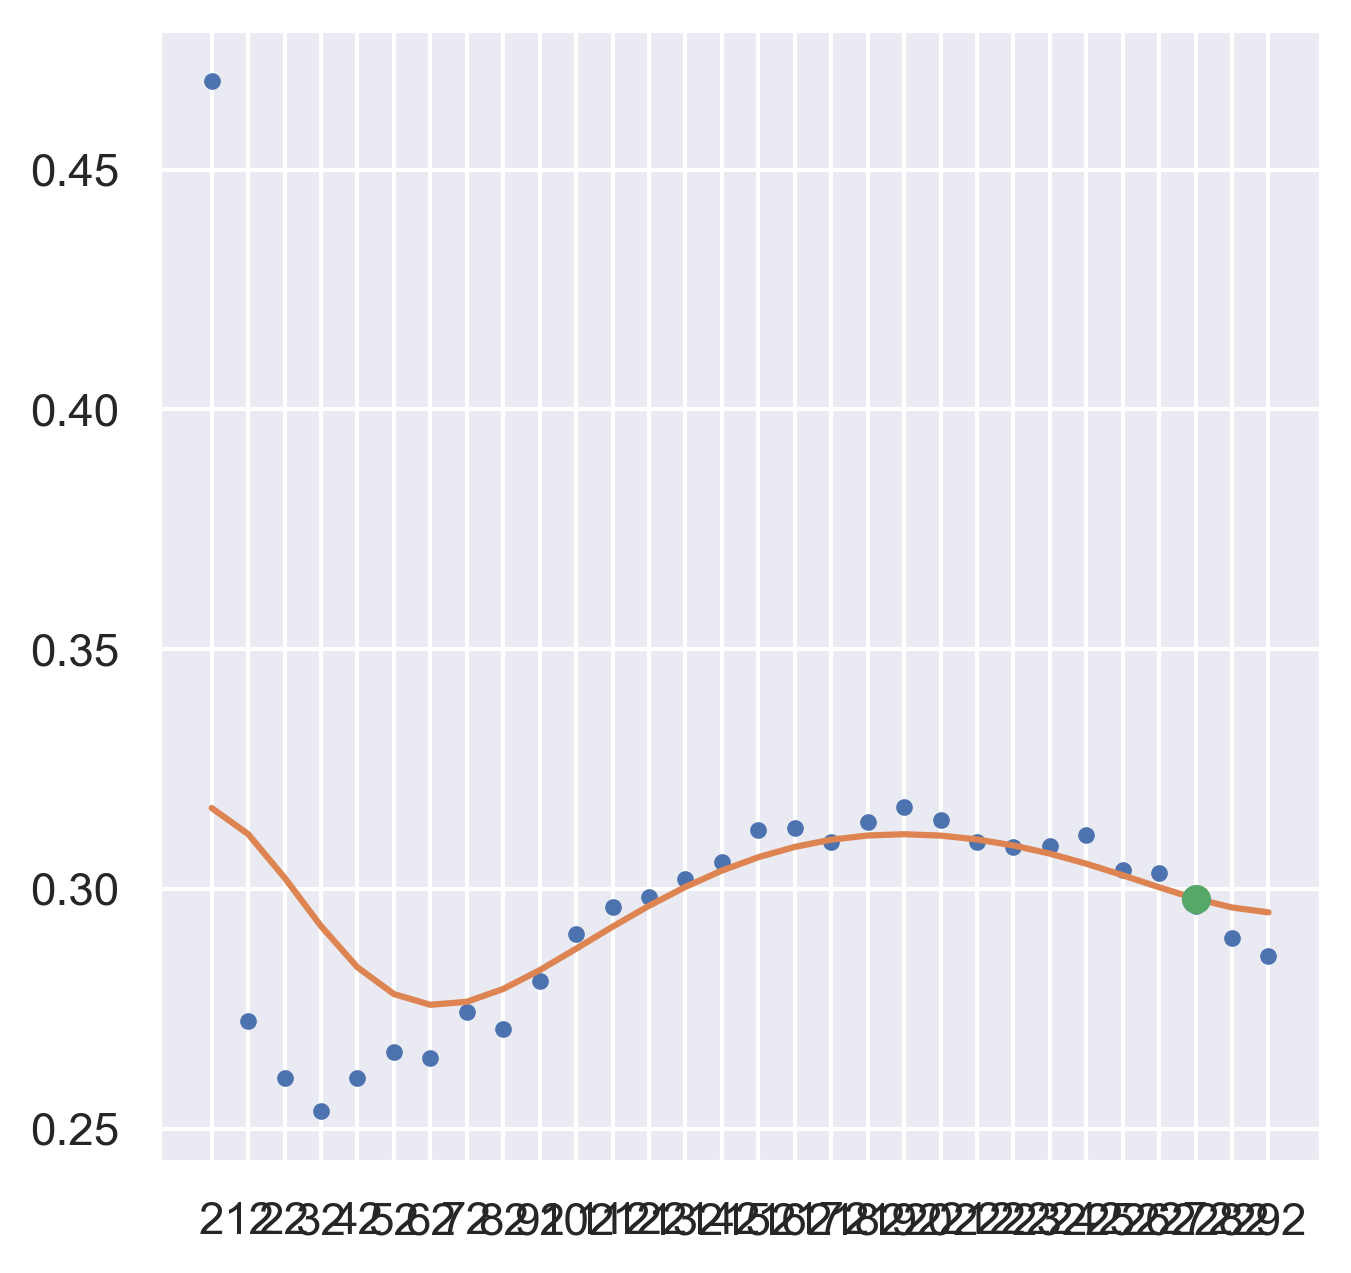

In [10]:
a = st.elbow_plot()


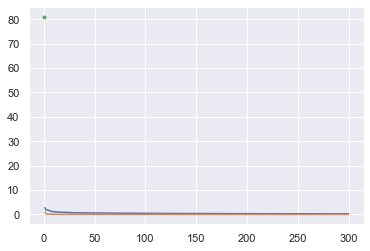

Try 81 clusters...


In [11]:
a = st.elbow_alt()

Try 2 clusters...
Try 32 clusters...


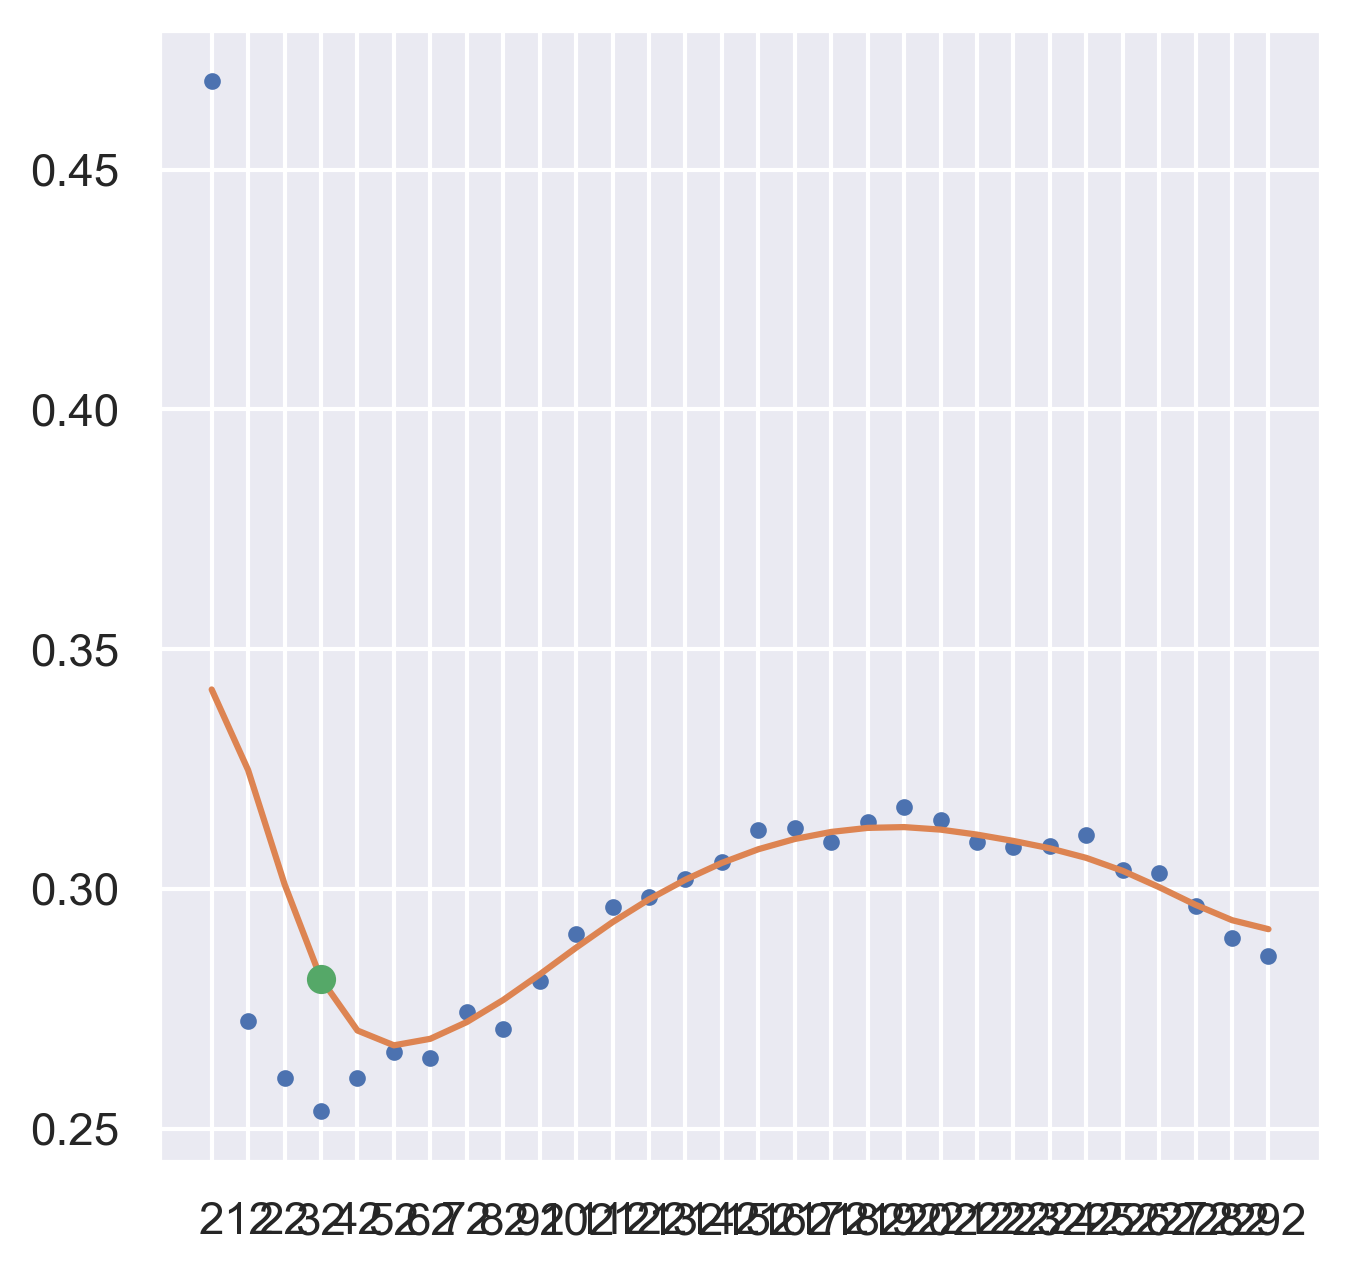

In [12]:
a = st.silhoutte_scores_n_clusters()

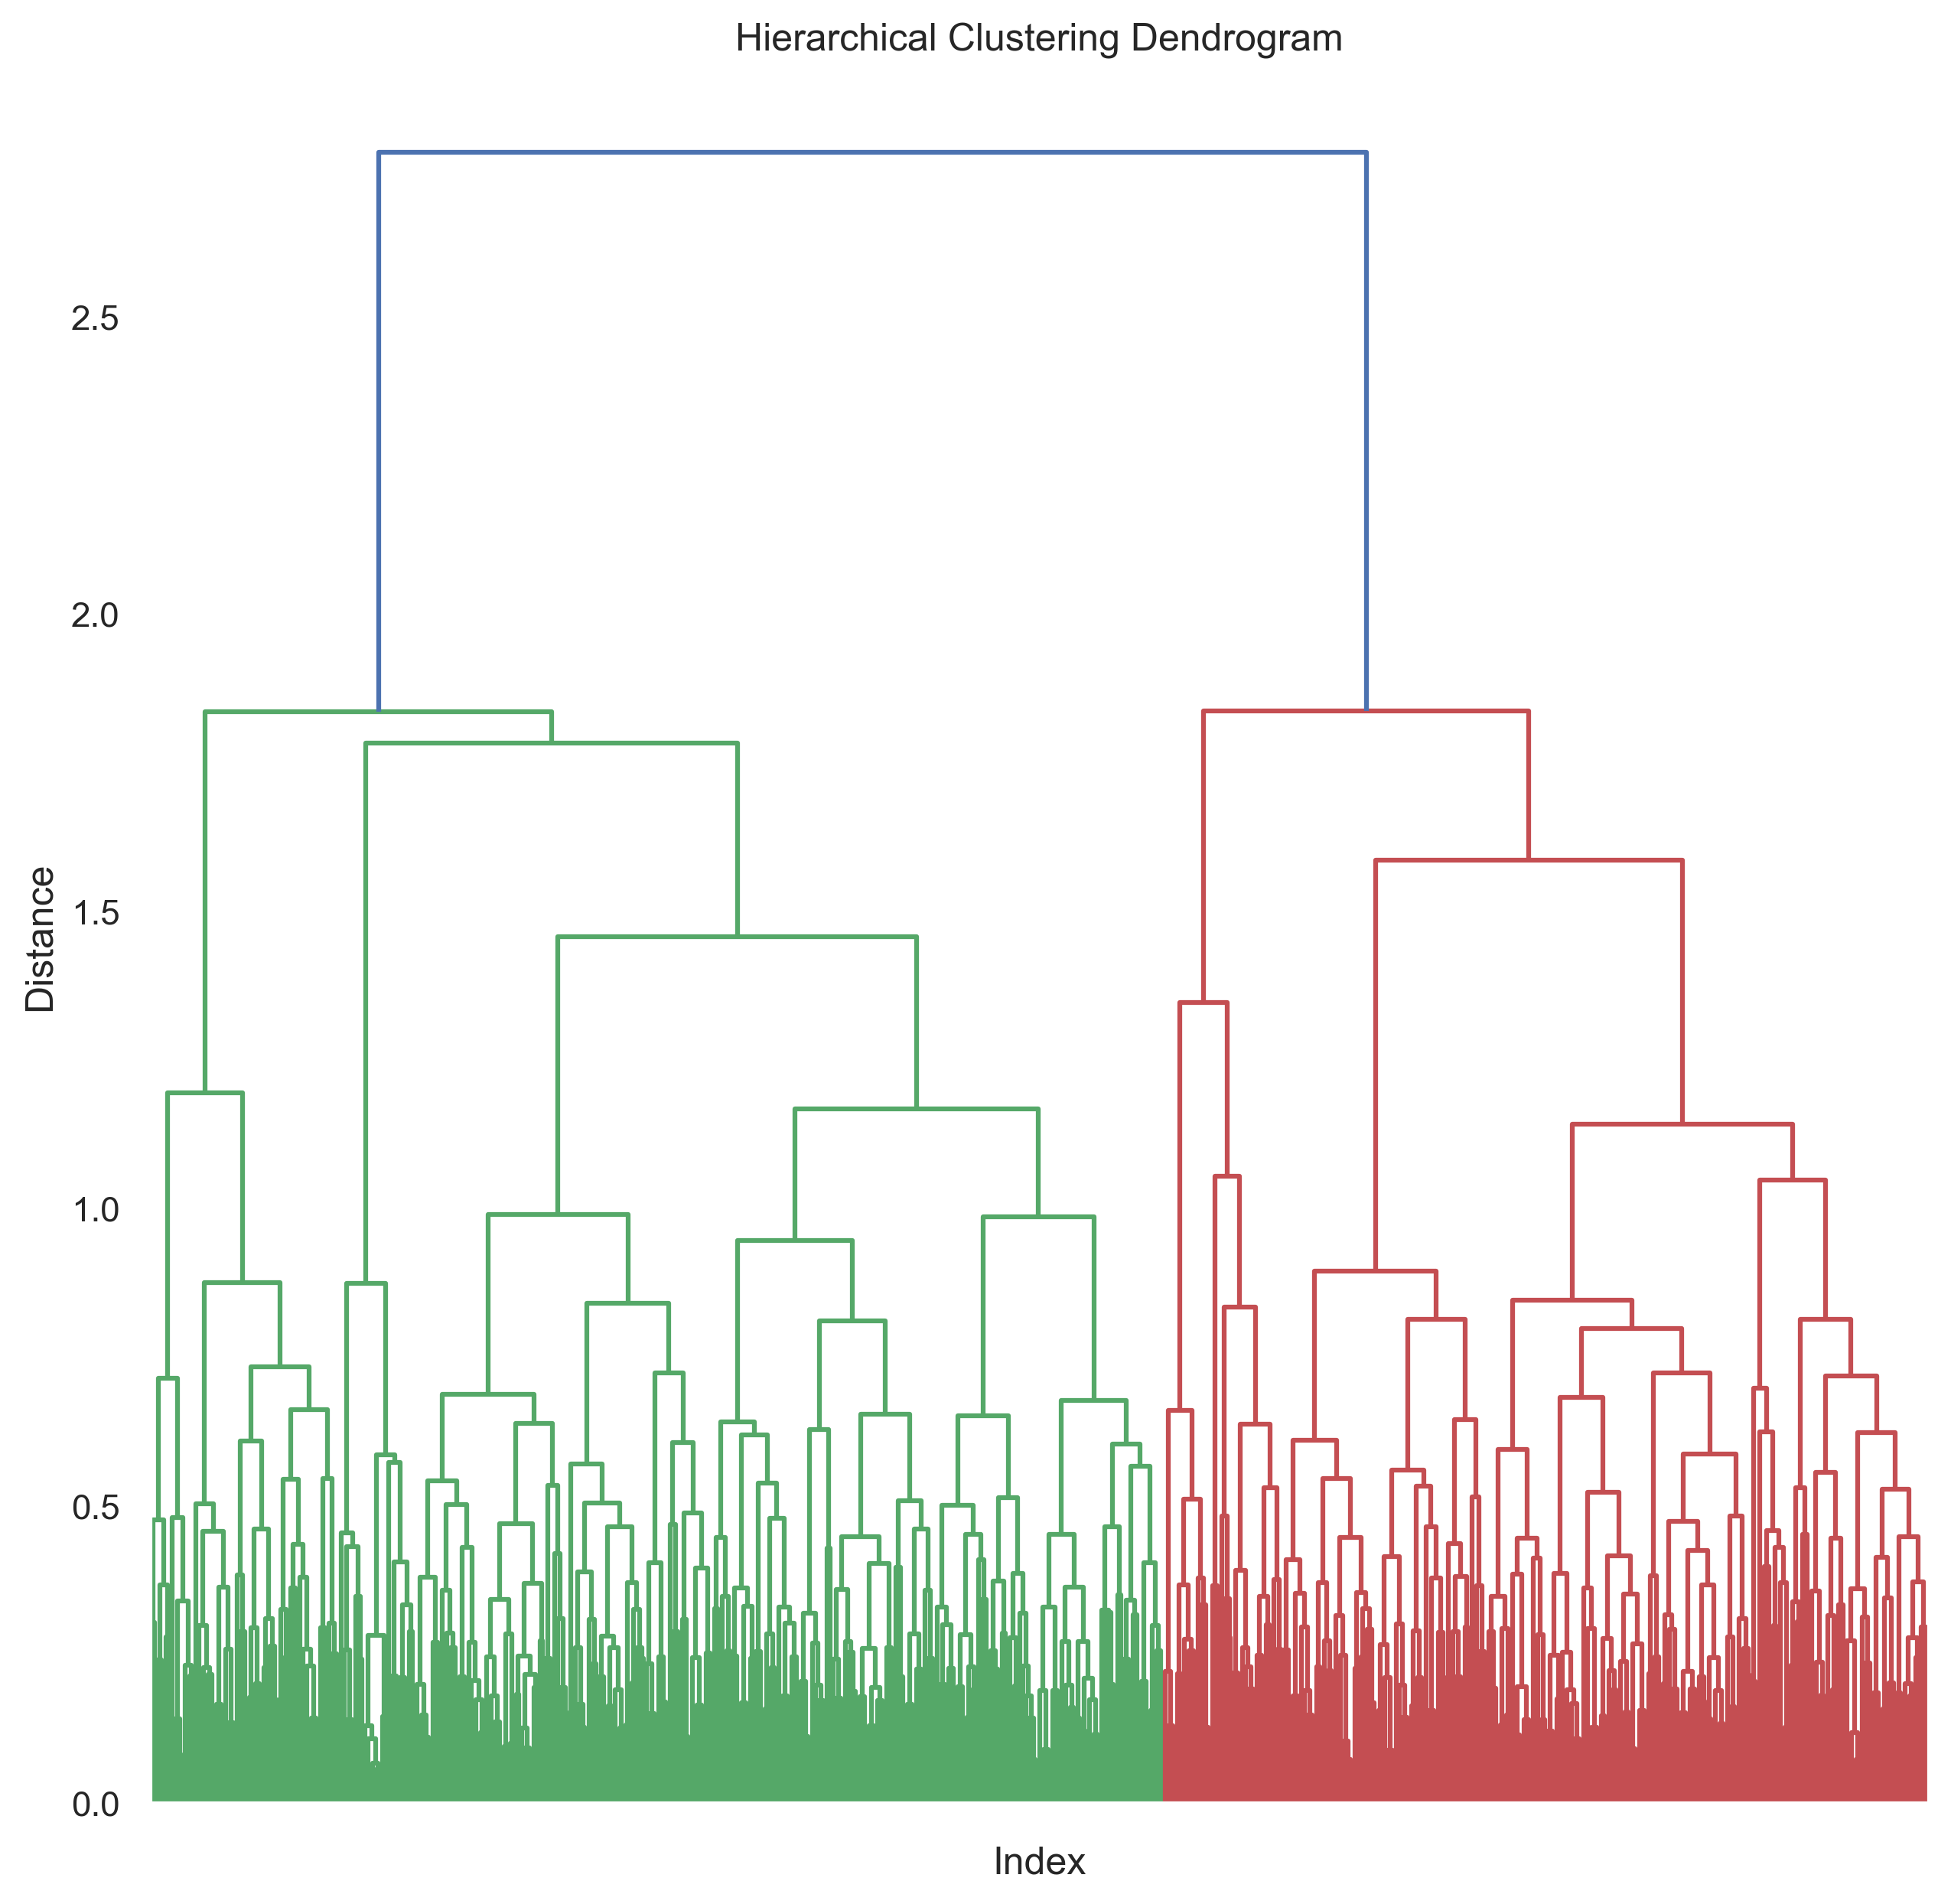

In [13]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

fig = plt.figure(figsize=(10,10),dpi=300)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
row_dendr = dendrogram(st.row_clusters)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.show()

In [14]:
cluster_labels = fcluster(st.row_clusters, 32, criterion='maxclust')

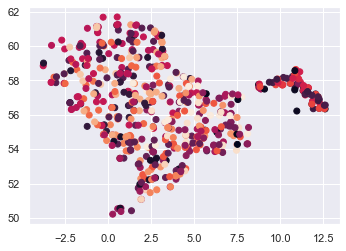

In [15]:
#gdf = gpd.GeoDataFrame(st.df,geometry=st.df[['ShootLong','ShootLat']].apply(lambda x: Point(x),axis=1),crs={'init': 'epsg:32631'})
gdf['clusters'] = cluster_labels
gdf.plot(column='clusters');

In [16]:
gdf.head()

,Unnamed: 0,Survey,Year,Quarter,DateTime,ShootLat,ShootLong,Depth,Gadus_morhua_juvenile,Gadus_morhua_adult,YearQuarter,dist_norm,timenorm,attnorm0,attnorm1,geometry,clusters
9696,14571,NS-IBTS,2005,3,08-09-2005 05:18:00 AM,55.4051,6.8233,27,0.000000,0.00000,30,1.665250,2.665250,1.0,1.0,POINT (6.82330 55.40510),10
3555,8531,NS-IBTS,1997,1,02-02-1997 01:01:00 PM,57.4000,2.2333,82,0.191282,0.00000,13,1.694028,2.694028,1.0,1.0,POINT (2.23330 57.40000),32
15075,20380,NS-IBTS,2013,3,31-07-2013 10:11:00 AM,57.0400,-1.8160,90,1.245227,0.00000,46,1.810284,2.810284,1.0,1.0,POINT (-1.81600 57.04000),15
4331,9237,NS-IBTS,1998,1,11-02-1998 11:41:00 AM,54.5667,3.3167,42,0.453392,100.90664,15,1.695666,2.695666,1.0,1.0,POINT (3.31670 54.56670),32
17868,23064,NS-IBTS,2017,3,21-07-2017 02:40:00 PM,52.3350,2.7437,45,0.000000,0.00000,54,1.688879,2.688879,1.0,1.0,POINT (2.74370 52.33500),3


In [17]:
#mindt = gdf['DateTime'].min()
mindt = gdf['YearQuarter'].min()
#gdf['fromstart'] = gdf['DateTime'].apply(lambda x: (x-mindt).days)
gdf['fromstart'] = gdf['YearQuarter'].apply(lambda x: (x - mindt))

Text(0.5, 0, 'YearQuarter')

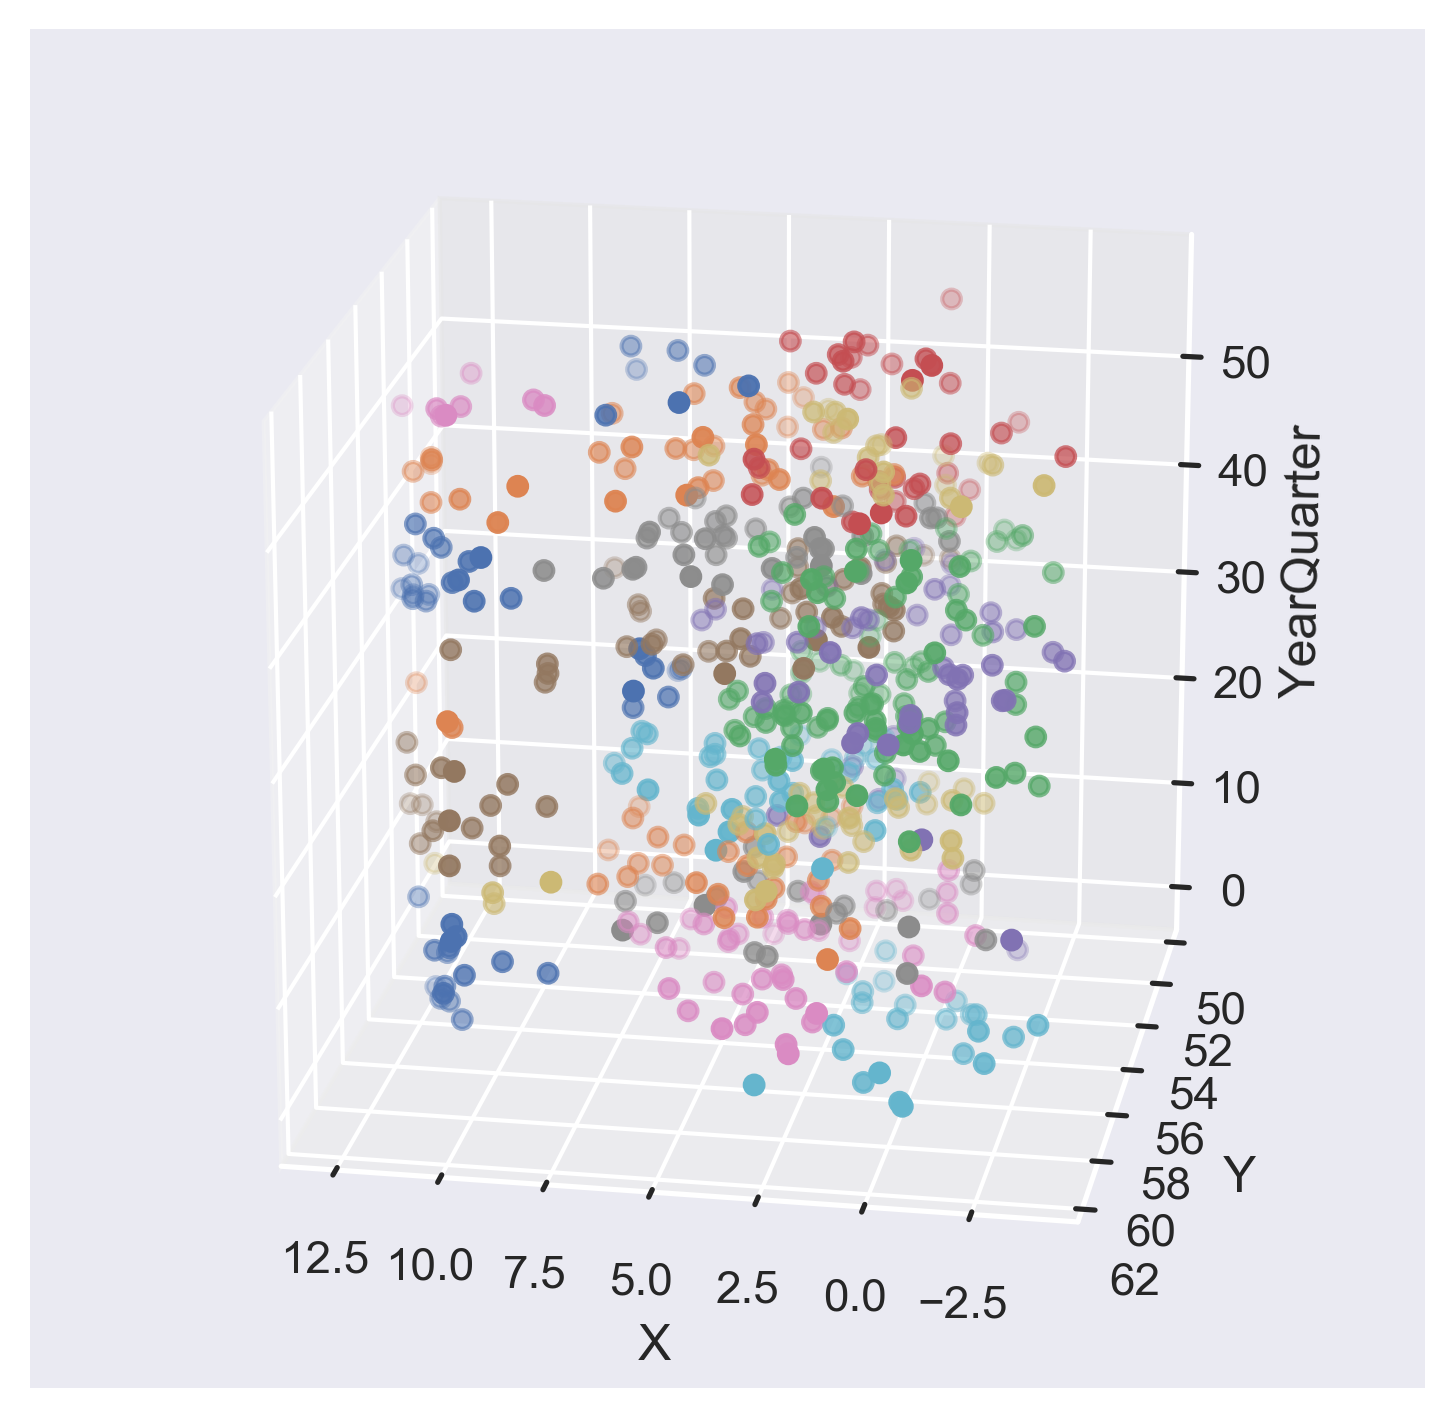

In [18]:
fig1 = plt.figure(figsize=(6,6),dpi=300)
ax1 = fig1.add_subplot(111, projection='3d')
#ax1.set_aspect('equal')
ax1.view_init(20, 100)

for c in gdf['clusters'].unique():
    vs = gdf[gdf['clusters']==c][['ShootLong','ShootLat','fromstart']].values
    ax1.scatter(vs[:,0],vs[:,1],vs[:,2])

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
#ax1.set_zlabel('Days');
ax1.set_zlabel('YearQuarter')

# Understanding the clusters

This will create three plots on one page: the location is plotted on an open street map background, the time is plotted as a scatter plot by index, and the attributes are plotted as a boxplot (one for each attribute).

In [26]:

import contextily as ctx

#If using contextily, the projection needs to be web mercator.

gdf = gdf.to_crs(epsg=4326)
#export gdf to plot in QGIS
gdf1 = pd.DataFrame(gdf)
gdf1.head()
gdf1.to_csv('/Users/markrademaker/Projects/Spatio_temporal_clustering/Data/cod_cluster_gdf.csv')

In [22]:
print(params['attributes']['fieldnames'])

['Gadus_morhua_juvenile', 'Gadus_morhua_adult']


In [20]:
for c in gdf['clusters'].unique():
    fig = plt.figure(figsize=(8,8),constrained_layout=True)
    gs = fig.add_gridspec(3, 3)
    ax_map = fig.add_subplot(gs[0:2, 0:])
    ax_map.set_aspect('equal')
    ax_map.set_title("Cluster {0} Coordinates".format(c))
    ax_timerange = fig.add_subplot(gs[2, 0])
    ax_variables = fig.add_subplot(gs[2, 1:])
    gdf[gdf['clusters']==c].plot(ax=ax_map)
    ax_map.set_xticks([])
    ax_map.set_yticks([])
    ax_map.set_xlim([gdf['geometry'].total_bounds[0],gdf['geometry'].total_bounds[2]])
    ax_map.set_ylim([gdf['geometry'].total_bounds[1],gdf['geometry'].total_bounds[3]])
    ctx.add_basemap(ax_map)
    ax_timerange.scatter(gdf[gdf['clusters']==c].index,gdf[gdf['clusters']==c][params['timedistance']['fieldnames']['datetime']])
    gdf[gdf['clusters']==c][params['attributes']['fieldnames']].boxplot(ax=ax_variables)
    plt.savefig("cluster_{0}.png".format(c),dpi=300)
    plt.close()

/Users/markrademaker/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/contextily/tile.py:629: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/Users/markrademaker/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/contextily/tile.py:629: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/Users/markrademaker/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/contextily/tile.py:629: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/Users/markrademaker/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/contextily/tile.py:629: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/Users/markrademaker/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/contextil

## Quarter instead of datetime

In [ ]:
from sthc import STHC
params = {"distance":{"fieldnames":{"x":"ShootLong","y":"ShootLat"},"function": lambda x,y: spatial.distance.cdist([x],y), 
                      "normalize_n": None, "normalize_k":12,"normalize_mean": False, "weights":1.0}, #Euclidean distance between two points, normalized by the maximum distance of the 6 nearest neighbors
          "timedistance":{"fieldnames":{"datetime":"DateTime"},"function": None, 
                  "normalize_n": 60, "normalize_k": None,"normalize_mean": False, "weights":1.0}, #Absolute distance in days, normalized by 60 days.
          "attributes":{"fieldnames":["Gadus_morhua_juvenile","Gadus_morhua_adult","Depth","Quarter"],
                        "function": [lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1),lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1),lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1),lambda x,y: np.abs(x-y)],
                        "normalize_n":[1,1,1,1], "normalize_k": [None,None,None,None], "normalize_mean": [False,False,False,False], "weights":[1.0,1.0,1.0,1.0]}} #Absolute difference between two values, normalized by the average of that field
name = "Gadus_morhua_1991_2019_juv_adult_biomass.csv"
ss = 600
st = STHC()
st.load_dataset_csv(name,params,32631,sample=ss) 

st.df.head()

In [ ]:
from scipy import spatial

st.calculate_distance_matrix()
st.calculate_clusters()
a = st.elbow_plot()

In [ ]:
fig = plt.figure(figsize=(10,10),dpi=300)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
row_dendr = dendrogram(st.row_clusters)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.show()

In [ ]:
cluster_labels = fcluster(st.row_clusters, 200, criterion='maxclust')
gdf = gpd.GeoDataFrame(st.df,geometry=st.df[['ShootLong','ShootLat']].apply(lambda x: Point(x),axis=1),crs={'init': 'epsg:32631'})
gdf['clusters'] = cluster_labels
gdf.plot(column='clusters');

In [ ]:
fig1 = plt.figure(figsize=(6,6),dpi=300)
ax1 = fig1.add_subplot(111, projection='3d')
#ax1.set_aspect('equal')
ax1.view_init(20, 100)

for c in gdf['clusters'].unique():
    vs = gdf[gdf['clusters']==c][['ShootLong','ShootLat','Quarter']].values
    ax1.scatter(vs[:,0],vs[:,1],vs[:,2])

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Quarter');

In [ ]:
fig1 = plt.figure(figsize=(6,6),dpi=300)
ax1 = fig1.add_subplot(111, projection='3d')
#ax1.set_aspect('equal')
ax1.view_init(20, 100)

for c in gdf['clusters'].unique():
    vs = gdf[gdf['clusters']==c][['ShootLong','ShootLat','Depth']].values
    ax1.scatter(vs[:,0],vs[:,1],vs[:,2])

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Depth');

In [ ]:
import contextily as ctx

#If using contextily, the projection needs to be web mercator.

gdf = gdf.to_crs(epsg=3857)

for c in gdf['clusters'].unique():
    fig = plt.figure(figsize=(8,8),constrained_layout=True)
    gs = fig.add_gridspec(3, 3)
    ax_map = fig.add_subplot(gs[0:2, 0:])
    ax_map.set_aspect('equal')
    ax_map.set_title("Cluster {0} Coordinates".format(c))
    ax_timerange = fig.add_subplot(gs[2, 0])
    ax_variables = fig.add_subplot(gs[2, 1:])
    gdf[gdf['clusters']==c].plot(ax=ax_map)
    ax_map.set_xticks([])
    ax_map.set_yticks([])
    ax_map.set_xlim([gdf['geometry'].total_bounds[0],gdf['geometry'].total_bounds[2]])
    ax_map.set_ylim([gdf['geometry'].total_bounds[1],gdf['geometry'].total_bounds[3]])
    ctx.add_basemap(ax_map)
    ax_timerange.scatter(gdf[gdf['clusters']==c].index,gdf[gdf['clusters']==c][params['timedistance']['fieldnames']['datetime']])
    
    gdf[gdf['clusters']==c][params['attributes']['fieldnames']].boxplot(ax=ax_variables)
    plt.savefig("comparison/cluster_{0}.png".format(c),dpi=300)
    plt.close()